In [2]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.9 MB/s eta 0:00:00:00:010:01


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import os
import nibabel as nib
import SimpleITK as sitk
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize
from tqdm import tqdm
import tensorflow_addons as tfa

In [216]:
size = 160

In [217]:
def load_image(path):
    img = pydicom.read_file(path)
    img = img.pixel_array
    return cv2.resize(img, (size,size))

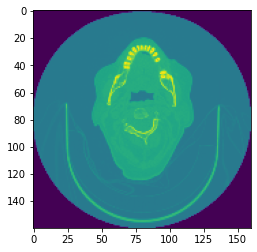

In [236]:
plt.imshow(load_image("../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10261/118.dcm"))

In [218]:
def window(img):
#     img[np.where(img<0)] = 0
#     img[np.where(img>1900)] = 1900
    minn = img.min()
    
    if minn<0:
        img = img + minn
    else:
        img = img - minn

    return (img)/img.max()

In [242]:
def channeling(img):
    return np.stack([img, img, img], axis=-1)

In [219]:
def extract(path):
   
    final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
    for image in range(1, len(os.listdir(path))):
        img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
        final_ct = np.append(final_ct, img, axis=0)
        
    resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
    for i in range(1,final_ct.shape[1]):
        resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

    return window(resized_final_ct)

In [238]:
bb_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [239]:
bb_df[['x', 'y', 'width', 'height']] = (bb_df[['x', 'y', 'width', 'height']]//3.2).astype(int)

In [241]:
bb_df[bb_df['StudyInstanceUID']=='1.2.826.0.1.3680043.9940']

,StudyInstanceUID,x,y,width,height,slice_number
7205,1.2.826.0.1.3680043.9940,99,34,17,22,133
7206,1.2.826.0.1.3680043.9940,95,34,23,21,134
7207,1.2.826.0.1.3680043.9940,95,34,23,21,135
7208,1.2.826.0.1.3680043.9940,95,35,22,21,136
7209,1.2.826.0.1.3680043.9940,95,35,22,22,137
7210,1.2.826.0.1.3680043.9940,94,35,24,21,138
7211,1.2.826.0.1.3680043.9940,93,35,25,23,139
7212,1.2.826.0.1.3680043.9940,92,36,26,20,140
7213,1.2.826.0.1.3680043.9940,93,36,26,19,141
7214,1.2.826.0.1.3680043.9940,93,37,27,18,142


In [229]:
patients = bb_df['StudyInstanceUID'].unique()

In [231]:
path = '../input/rsna-2022-cervical-spine-fracture-detection/train_images/'
def data_gen_positive():
    for patient in patients:
        p_df = bb_df[bb_df['StudyInstanceUID'] == patient]
        ct = extract(path+patient)
        for img in range(p_df.shape[0]):
            slice_number = np.random.randint(p_df['x'], p_df['width'])
            yield channeling(ct), 1

235

In [226]:
t = 4
n_all = t*7217
n_80 = ((t*7217)*(8))//10
deviation = n_all//1058 
np_list = np.arange(0,7217*t)
random_list = np.random.choice(np_list,7217*t,replace=False)

def data_gen():
    for i in random_list[:n_80]:
        if i%4!=0:
            try:
                label = 0
                img = window(load_image(path+df.iloc[int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[int(deviation)]["StudyInstanceUID"]))))+".dcm"))
                yield channeling(img),label
            except:
                continue

        else:         
            label = 1
            img = window(load_image(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm"))
            yield channeling(img),label
        
        
def test_gen():
    for i in random_list[n_80:]:
        if i%4!=0:
            try:
                label = 0
                img = window(load_image(path+df.iloc[int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[int(deviation)]["StudyInstanceUID"]))))+".dcm"))
                yield channeling(img),label
            except:
                continue

        else:         
            label = 1
            img = window(load_image(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm"))
            yield channeling(img),label